# All Default Models (with normalizing outliers)

In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
import seaborn as sns
pd.set_option("display.max_columns",None)
# pd.set_option("display.max_rows",None)
from scipy.stats import shapiro,mannwhitneyu,chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from IPython.display import Image
# from sklearn.tree import export_graphviz
import imblearn


from numpy.random import seed
from numpy.random import randn
from numpy import mean
from numpy import std


import warnings 
warnings.filterwarnings('ignore')

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier 
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report,confusion_matrix

In [3]:
df = pd.read_csv('C:/Users/nabee/Desktop/CIND 820/Shoppers Data Set.csv')
dfwork = df.copy()

In [4]:
# Changing Column Types
dfwork['OperatingSystems'] = dfwork['OperatingSystems'].astype('object')
dfwork['Browser'] = dfwork['Browser'].astype('object')
dfwork['Region'] = dfwork['Region'].astype('object')
dfwork['TrafficType'] = dfwork['TrafficType'].astype('object')
dfwork['SpecialDay'] = dfwork['SpecialDay'].astype('object')

In [5]:
# getting list of numerical and categorical columns
num = dfwork.select_dtypes(include=np.number)
cat = dfwork.select_dtypes(exclude=np.number)

In [6]:
# one hot encoding
dfwork['Weekend'].replace({False:0,True:1},inplace =True)
dfwork['Revenue'].replace({False:0,True:1},inplace =True)
dfwork.drop(['Region'],axis  = 1,inplace = True)
dfwork = pd.get_dummies(dfwork, columns = ['Month','VisitorType','Browser','OperatingSystems','TrafficType'])

In [7]:
#Applying  transformation
dfwork['Administrative_Duration'],pd = st.boxcox(dfwork['Administrative_Duration']+1)
dfwork['Informational_Duration'],pd = st.boxcox(dfwork['Informational_Duration']+1)
dfwork['ProductRelated_Duration'],pd = st.boxcox(dfwork['ProductRelated_Duration']+1)
# dfwork['BounceRates'],pd = st.boxcox(dfwork['BounceRates']+1)
# dfwork['ExitRates'],pd = st.boxcox(dfwork['ExitRates']+1)
dfwork['BounceRates'] = dfwork['BounceRates']**0.2 
dfwork['ExitRates'] =dfwork['ExitRates']**0.2 
dfwork['PageValues'],pd = st.boxcox(dfwork['PageValues']+1)

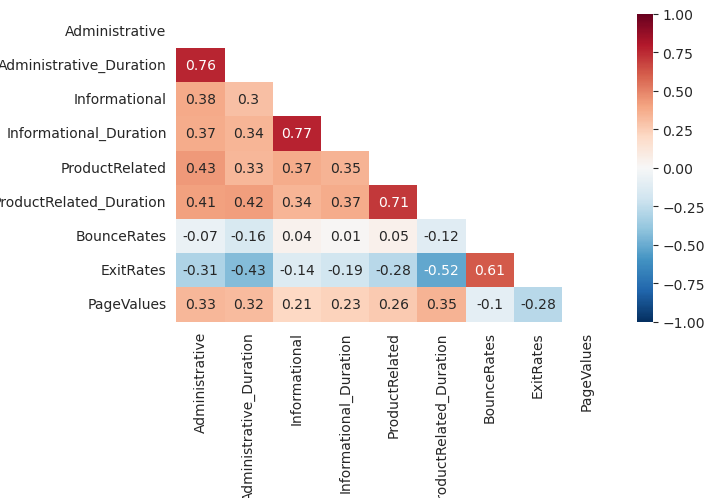

In [8]:
# Check for correlation
corr = dfwork.iloc[: , :9].corr().round(2)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(7,4))
    sns.heatmap(ax=ax, data=corr, mask=mask, annot=True, center=0, vmin=-1, vmax=1, cmap="RdBu_r");
    fig.savefig('heatmap.png')

In [21]:
df_vifcheck = dfwork.copy()
df_vif = df_vifcheck[['Administrative','Administrative_Duration','Informational'
                  ,'Informational_Duration','ProductRelated','ProductRelated_Duration','BounceRates','ExitRates','PageValues']]
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [ ]:
# X = df_vif
# calc_vif(X)

# Feature Selection

In [9]:
import pandas as pd
cat_cols=['SpecialDay','Weekend',
        'TrafficType_1','TrafficType_2','TrafficType_3','TrafficType_4','TrafficType_5','TrafficType_6','TrafficType_8','TrafficType_10' , 
        'TrafficType_11','TrafficType_13',
        'Browser_1','Browser_2','Browser_3','Browser_4','Browser_5','Browser_6','Browser_8','Browser_10', 
        'OperatingSystems_1', 'OperatingSystems_2','OperatingSystems_3', 'OperatingSystems_4', 'OperatingSystems_8',
        'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June',
        'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
        'VisitorType_New_Visitor', 'VisitorType_Other','VisitorType_Returning_Visitor']
scol = []
spval = []
ss = []
for n in cat_cols:
    scol.append(n)
    cp = chi2_contingency(pd.crosstab(dfwork[n], dfwork['Revenue']))[1]
    spval.append(round(cp, 4))
    if cp < 0.05:
        # rejects Null Hypothesis
        ss.append('Yes') # significant
    else:
        # Accept Null Hypothesis
        ss.append('No') # not significant
sign_catcol = pd.DataFrame({'Feature': scol, 'P-Value': spval, 'Significance': ss})
sign_catcol = sign_catcol[sign_catcol['Significance'] == 'No'] 
sign_catcol = list(sign_catcol['Feature'])
# sign_catcol.sort_values(by=['Significance','P-Value'], ascending=[False,True])

In [10]:
from scipy.stats import levene
numerical_columns=['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues']
# Two-Sample T-test
tcol = []
tpval = []
ts = []
for n in numerical_columns:
    tcol.append(n)
    # splitting into 2 groups(Revenue = True, Revenue = False)
    g1 = dfwork[n][dfwork['Revenue'] == False]
    g2 = dfwork[n][dfwork['Revenue'] == True]
    # Test for normality(Shapiro Test)
    # H0: Data is normal
    # H1: Data is not normal
    # if p < 0.05 --- reject Null Hypothesis
    for b in [g1]:
        s, p = shapiro(b)
    for c in [g2]:
        s1, p1 = shapiro(c)
    if p > 0.05 or p1 > 0.05:
        w, lp = levene(g1, g2)
    # If doesn't pass normality or variance test, we do non-parametric Test(mannwhitneyu Test)
    if p <= 0.05 or p1 <= 0.05 or lp <= 0.05:
        ms, mp = mannwhitneyu(g1, g2)
        tpval.append(round(mp, 4))
    if mp < 0.05:
        ts.append('Yes')  # significant
    else:
        ts.append('No') # not significant
sign_numcol = pd.DataFrame({'Feature': tcol, 'P-Value': tpval, 'Significance': ts})
# sign_numcol = list(sign_numcol['Feature'])

In [11]:
dfwork = dfwork.drop(sign_catcol, axis=1)
dfwork.head(2)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Weekend,Revenue,Month_Dec,Month_Feb,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Returning_Visitor,Browser_3,Browser_7,Browser_9,Browser_11,Browser_12,Browser_13,OperatingSystems_2,OperatingSystems_3,OperatingSystems_5,OperatingSystems_6,OperatingSystems_7,TrafficType_1,TrafficType_2,TrafficType_3,TrafficType_5,TrafficType_6,TrafficType_7,TrafficType_8,TrafficType_9,TrafficType_10,TrafficType_12,TrafficType_13,TrafficType_14,TrafficType_15,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20
0,0,0.0,0,0.0,1,0.000000,0.72478,0.724780,0.0,0.0,0,0,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,0,0.0,0,0.0,2,6.990788,0.00000,0.630957,0.0,0.0,0,0,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [19]:
colnames = ['Month_Dec','Month_Feb','Month_June','Month_Mar','Month_May','Month_Nov','Month_Oct','Month_Sep','VisitorType_New_Visitor','VisitorType_Returning_Visitor','Browser_3','Browser_7','Browser_9','Browser_11','Browser_12','Browser_13','OperatingSystems_2','OperatingSystems_3','OperatingSystems_5','OperatingSystems_6','OperatingSystems_7','TrafficType_1','TrafficType_2','TrafficType_3','TrafficType_5','TrafficType_6','TrafficType_7','TrafficType_8','TrafficType_9','TrafficType_10','TrafficType_12','TrafficType_13','TrafficType_14','TrafficType_15','TrafficType_16','TrafficType_17','TrafficType_18','TrafficType_19','TrafficType_20']
for x in colnames:
    dfwork[x].replace({False:0,True:1},inplace =True)

In [22]:
from pathlib import Path  
filepath = Path('C:/Users/nabee/Desktop/CIND 820/dffinal.csv')  
# filepath.parent.mkdir(parents=True, exist_ok=True)  
dfwork.to_csv(filepath) 

In [12]:
# from sklearn.feature_selection import SelectKBest, f_classif

# X = dfwork_v1.drop('Revenue', axis=1)
# y = dfwork_v1.Revenue
# selector = SelectKBest(f_classif, k = 32)
# X_new = selector.fit_transform(X, y)
# column_nameskbest = [column[0]  for column in zip(X.columns,selector.get_support()) if column[1]]
# column_nameskbest

In [13]:
#Splitting Train and Test Data Set
y = dfwork['Revenue']
x = dfwork.drop(['Revenue'], axis = 1)

# checking the shapes
print("Shape of x: ", x.shape)
print("Shape of y: ", y.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size =  0.2, random_state = 0)

print("Shape of x_train :", x_train.shape)
print("Shape of y_train :", y_train.shape)
print("Shape of x_test :", x_test.shape)
print("Shape of y_test :", y_test.shape)

Shape of x:  (12330, 50)
Shape of y:  (12330,)
Shape of x_train : (9864, 50)
Shape of y_train : (9864,)
Shape of x_test : (2466, 50)
Shape of y_test : (2466,)


In [14]:
# Min Max Scaler 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()    
scaler.fit(x_train)       
x_train = scaler.transform(x_train)    
x_test = scaler.transform(x_test)

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

LR = LogisticRegression()
LR.fit(x_train, y_train)
y_pred_lr = LR.predict(x_test)

rf = RandomForestClassifier().fit(x_train,y_train)
y_pred_rf = rf.predict(x_test)

dt = DecisionTreeClassifier().fit(x_train,y_train)
y_pred_dt = dt.predict(x_test)

nb = GaussianNB().fit(x_train,y_train)
y_pred_nb = nb.predict(x_test)

svc = SVC().fit(x_train,y_train)
y_pred_svm = svc.predict(x_test)

ada = AdaBoostClassifier().fit(x_train,y_train)
y_pred_ada = ada.predict(x_test)

gbc = GradientBoostingClassifier().fit(x_train,y_train)
y_pred_gbc = gbc.predict(x_test)

gb = xgb.XGBClassifier().fit(x_train,y_train)
y_pred_gb = gb.predict(x_test)

## Logistic Regression

************************************* Confusion Matrix ******************************************


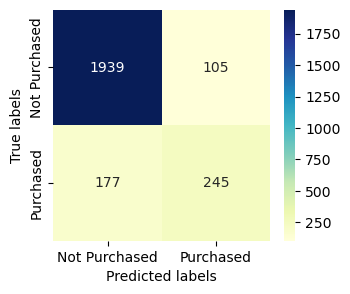

************************************* Classification Report *************************************
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      2044
           1       0.70      0.58      0.63       422

    accuracy                           0.89      2466
   macro avg       0.81      0.76      0.78      2466
weighted avg       0.88      0.89      0.88      2466

************************************* description Table *****************************************


,Description,Misclassifications,Accuracy,Precision,Recall Minority,Recall Majority,Type I errors,Type II errors,F1 Score,F2 Score
0,Logistic Regression,282,0.89,0.7,0.58,0.95,105,177,0.63,0.6


In [16]:

cmlr = metrics.confusion_matrix(y_test, y_pred_lr)
plt.rcParams['figure.figsize'] = (3.5, 3)
ax = sns.heatmap(cmlr, fmt = 'g',annot = True,cmap="YlGnBu")
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');  
ax.xaxis.set_ticklabels(['Not Purchased', 'Purchased']); ax.yaxis.set_ticklabels(['Not Purchased', 'Purchased'])
print ("************************************* Confusion Matrix ******************************************")
plt.show()

print ("************************************* Classification Report *************************************")
crlr = metrics.classification_report(y_test,y_pred_lr)
print(crlr)

print ("************************************* description Table *****************************************")
description = "Logistic Regression"  #change the name of models
# cmbase = cmbaselr

misclassifications = cmlr[0,1] + cmlr[1,0]         #FP + FN
type1 = cmlr[0,1]
type2 = cmlr[1,0]
r1 = (cmlr[1,1]  / (cmlr[1,1] + cmlr[1,0])).round(2)
r0 = (cmlr[0,0]  / (cmlr[0,0] + cmlr[0,1])).round(2)
precision = round(precision_score(y_test, y_pred_lr),2)
recall = round(recall_score(y_test,y_pred_lr),2)
accuracy = round(accuracy_score(y_test,y_pred_lr),2)
f1 = round(f1_score(y_test,y_pred_lr),2)
auc = round(roc_auc_score(y_test,y_pred_lr),2)
f2 = ((5 * precision * recall)/ (4 * precision + recall)).round(2)
df_results = pd.DataFrame(np.array([description,misclassifications,accuracy, precision, r1,r0,type1,type2,f1,f2]).reshape(1,-1)
                                     , columns=['Description','Misclassifications','Accuracy','Precision','Recall Minority','Recall Majority'
                                                ,'Type I errors','Type II errors','F1 Score','F2 Score'])
                                  # ], axis=0)
df_results

## Random Forest

************************************* Confusion Matrix ******************************************


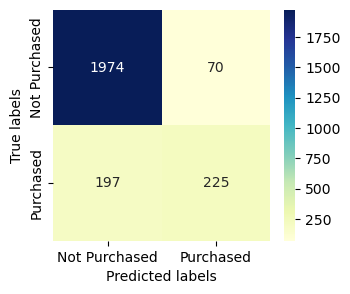

************************************* Classification Report *************************************
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      2044
           1       0.76      0.53      0.63       422

    accuracy                           0.89      2466
   macro avg       0.84      0.75      0.78      2466
weighted avg       0.88      0.89      0.88      2466

************************************* description Table *****************************************


,Description,Misclassifications,Accuracy,Precision,Recall Minority,Recall Majority,Type I errors,Type II errors,F1 Score,F2 Score
0,Logistic Regression,282,0.89,0.7,0.58,0.95,105,177,0.63,0.6
0,Random Forest Classifier,267,0.89,0.76,0.53,0.97,70,197,0.63,0.56


In [17]:

cmrf = metrics.confusion_matrix(y_test, y_pred_rf)
plt.rcParams['figure.figsize'] = (3.5, 3)
ax = sns.heatmap(cmrf, fmt = 'g',annot = True,cmap="YlGnBu")
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');  
ax.xaxis.set_ticklabels(['Not Purchased', 'Purchased']); ax.yaxis.set_ticklabels(['Not Purchased', 'Purchased'])
print ("************************************* Confusion Matrix ******************************************")
plt.show()

print ("************************************* Classification Report *************************************")
crrf = metrics.classification_report(y_test,y_pred_rf)
print(crrf)

print ("************************************* description Table *****************************************")
description = "Random Forest Classifier"  #change the name of models


rfmisclassifications = cmrf[0,1] + cmrf[1,0]         #FP + FN
rftype1 = cmrf[0,1]
rftype2 = cmrf[1,0]
rfr1 = (cmrf[1,1]  / (cmrf[1,1] + cmrf[1,0])).round(2)
rfr0 = (cmrf[0,0]  / (cmrf[0,0] + cmrf[0,1])).round(2)
rfprecision = round(precision_score(y_test, y_pred_rf),2)
rfrecall = round(recall_score(y_test,y_pred_rf),2)
rfaccuracy = round(accuracy_score(y_test,y_pred_rf),2)
rff1 = round(f1_score(y_test,y_pred_rf),2)
rfauc = round(roc_auc_score(y_test,y_pred_rf),2)
rff2 = ((5 * rfprecision * rfrecall)/ (4 * rfprecision + rfrecall)).round(2)

df_results = pd.concat([df_results,pd.DataFrame(np.array
                                                ([description,rfmisclassifications,rfaccuracy, rfprecision, rfr1,rfr0,rftype1,rftype2,rff1,rff2]).reshape(1,-1)
                                     , columns=['Description','Misclassifications','Accuracy','Precision','Recall Minority','Recall Majority'
                                                ,'Type I errors','Type II errors','F1 Score','F2 Score'])
                                  ], axis=0)
df_results

# Naive Bayes CLassifier (Gaussian)

************************************* Confusion Matrix ******************************************


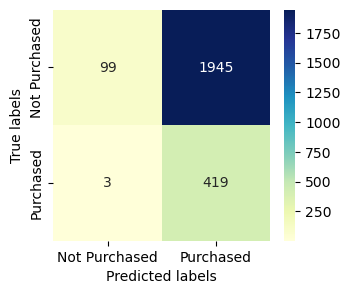

************************************* Classification Report *************************************
              precision    recall  f1-score   support

           0       0.97      0.05      0.09      2044
           1       0.18      0.99      0.30       422

    accuracy                           0.21      2466
   macro avg       0.57      0.52      0.20      2466
weighted avg       0.83      0.21      0.13      2466

************************************* description Table *****************************************


,Description,Misclassifications,Accuracy,Precision,Recall Minority,Recall Majority,Type I errors,Type II errors,F1 Score,F2 Score
0,Logistic Regression,282,0.89,0.7,0.58,0.95,105,177,0.63,0.6
0,Random Forest Classifier,267,0.89,0.76,0.53,0.97,70,197,0.63,0.56
0,Naiye Bayes Classifier,1948,0.21,0.18,0.99,0.05,1945,3,0.3,0.52


In [18]:
cmnb = metrics.confusion_matrix(y_test, y_pred_nb)
plt.rcParams['figure.figsize'] = (3.5, 3)
ax = sns.heatmap(cmnb, fmt = 'g',annot = True,cmap="YlGnBu")
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');  
ax.xaxis.set_ticklabels(['Not Purchased', 'Purchased']); ax.yaxis.set_ticklabels(['Not Purchased', 'Purchased'])
print ("************************************* Confusion Matrix ******************************************")
plt.show()

print ("************************************* Classification Report *************************************")
crnb = metrics.classification_report(y_test,y_pred_nb)
print(crnb)

print ("************************************* description Table *****************************************")
description = "Naiye Bayes Classifier"  #change the name of models


nbmisclassifications = cmnb[0,1] + cmnb[1,0]         #FP + FN
nbtype1 = cmnb[0,1]
nbtype2 = cmnb[1,0]
nbr1 = (cmnb[1,1]  / (cmnb[1,1] + cmnb[1,0])).round(2)
nbr0 = (cmnb[0,0]  / (cmnb[0,0] + cmnb[0,1])).round(2)
nbprecision = round(precision_score(y_test, y_pred_nb),2)
nbrecall = round(recall_score(y_test,y_pred_nb),2)
nbaccuracy = round(accuracy_score(y_test,y_pred_nb),2)
nbf1 = round(f1_score(y_test,y_pred_nb),2)
nbauc = round(roc_auc_score(y_test,y_pred_nb),2)
nbf2 = ((5 * nbprecision * nbrecall)/ (4 * nbprecision + nbrecall)).round(2)

df_results = pd.concat([df_results,pd.DataFrame(np.array
                                                ([description,nbmisclassifications,nbaccuracy, nbprecision, nbr1,nbr0,nbtype1,nbtype2,nbf1,nbf2]).reshape(1,-1)
                                     , columns=['Description','Misclassifications','Accuracy','Precision','Recall Minority','Recall Majority'
                                                ,'Type I errors','Type II errors','F1 Score','F2 Score'])
                                  ], axis=0)
df_results

## Decision Tree Classifier

************************************* Confusion Matrix ******************************************


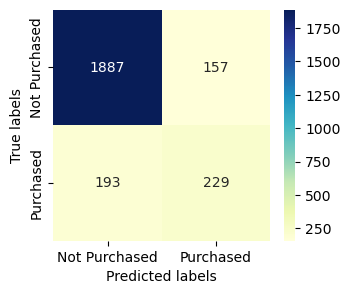

************************************* Classification Report *************************************
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      2044
           1       0.59      0.54      0.57       422

    accuracy                           0.86      2466
   macro avg       0.75      0.73      0.74      2466
weighted avg       0.85      0.86      0.86      2466

************************************* description Table *****************************************


,Description,Misclassifications,Accuracy,Precision,Recall Minority,Recall Majority,Type I errors,Type II errors,F1 Score,F2 Score
0,Logistic Regression,282,0.89,0.7,0.58,0.95,105,177,0.63,0.6
0,Random Forest Classifier,267,0.89,0.76,0.53,0.97,70,197,0.63,0.56
0,Naiye Bayes Classifier,1948,0.21,0.18,0.99,0.05,1945,3,0.3,0.52
0,Decision Tree Classifier,350,0.86,0.59,0.54,0.92,157,193,0.57,0.55


In [19]:

cmdt = metrics.confusion_matrix(y_test, y_pred_dt)
plt.rcParams['figure.figsize'] = (3.5, 3)
ax = sns.heatmap(cmdt, fmt = 'g',annot = True,cmap="YlGnBu")
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');  
ax.xaxis.set_ticklabels(['Not Purchased', 'Purchased']); ax.yaxis.set_ticklabels(['Not Purchased', 'Purchased'])
print ("************************************* Confusion Matrix ******************************************")
plt.show()

print ("************************************* Classification Report *************************************")
crdt = metrics.classification_report(y_test,y_pred_dt)
print(crdt)

print ("************************************* description Table *****************************************")
description = "Decision Tree Classifier"  #change the name of models


dtmisclassifications = cmdt[0,1] + cmdt[1,0]         #FP + FN
dttype1 = cmdt[0,1]
dttype2 = cmdt[1,0]
dtr1 = (cmdt[1,1]  / (cmdt[1,1] + cmdt[1,0])).round(2)
dtr0 = (cmdt[0,0]  / (cmdt[0,0] + cmdt[0,1])).round(2)
dtprecision = round(precision_score(y_test, y_pred_dt),2)
dtrecall = round(recall_score(y_test,y_pred_dt),2)
dtaccuracy = round(accuracy_score(y_test,y_pred_dt),2)
dtf1 = round(f1_score(y_test,y_pred_dt),2)
dtauc = round(roc_auc_score(y_test,y_pred_dt),2)
dtf2 = ((5 * dtprecision * dtrecall)/ (4 * dtprecision + dtrecall)).round(2)

df_results = pd.concat([df_results,pd.DataFrame(np.array
                                                ([description,dtmisclassifications,dtaccuracy, dtprecision, dtr1,dtr0,dttype1,dttype2,dtf1,dtf2]).reshape(1,-1)
                                     , columns=['Description','Misclassifications','Accuracy','Precision','Recall Minority','Recall Majority'
                                                ,'Type I errors','Type II errors','F1 Score','F2 Score'])
                                  ], axis=0)
df_results

## Support Vector Classifier

************************************* Confusion Matrix ******************************************


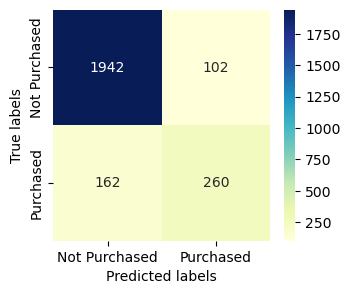

************************************* Classification Report *************************************
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      2044
           1       0.72      0.62      0.66       422

    accuracy                           0.89      2466
   macro avg       0.82      0.78      0.80      2466
weighted avg       0.89      0.89      0.89      2466

************************************* description Table *****************************************


,Description,Misclassifications,Accuracy,Precision,Recall Minority,Recall Majority,Type I errors,Type II errors,F1 Score,F2 Score
0,Logistic Regression,282,0.89,0.7,0.58,0.95,105,177,0.63,0.6
0,Random Forest Classifier,267,0.89,0.76,0.53,0.97,70,197,0.63,0.56
0,Naiye Bayes Classifier,1948,0.21,0.18,0.99,0.05,1945,3,0.3,0.52
0,Decision Tree Classifier,350,0.86,0.59,0.54,0.92,157,193,0.57,0.55
0,Support Vector Classifier,264,0.89,0.72,0.62,0.95,102,162,0.66,0.64


In [20]:
cmsv = metrics.confusion_matrix(y_test, y_pred_svm)
plt.rcParams['figure.figsize'] = (3.5, 3)
ax = sns.heatmap(cmsv, fmt = 'g',annot = True,cmap="YlGnBu")
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');  
ax.xaxis.set_ticklabels(['Not Purchased', 'Purchased']); ax.yaxis.set_ticklabels(['Not Purchased', 'Purchased'])
print ("************************************* Confusion Matrix ******************************************")
plt.show()

print ("************************************* Classification Report *************************************")
crsv = metrics.classification_report(y_test,y_pred_svm)
print(crsv)

print ("************************************* description Table *****************************************")
description = "Support Vector Classifier"  #change the name of models


svmisclassifications = cmsv[0,1] + cmsv[1,0]         #FP + FN
svtype1 = cmsv[0,1]
svtype2 = cmsv[1,0]
svr1 = (cmsv[1,1]  / (cmsv[1,1] + cmsv[1,0])).round(2)
svr0 = (cmsv[0,0]  / (cmsv[0,0] + cmsv[0,1])).round(2)
svprecision = round(precision_score(y_test, y_pred_svm),2)
svrecall = round(recall_score(y_test,y_pred_svm),2)
svaccuracy = round(accuracy_score(y_test,y_pred_svm),2)
svf1 = round(f1_score(y_test,y_pred_svm),2)
svauc = round(roc_auc_score(y_test,y_pred_svm),2)
svf2 = ((5 * svprecision * svrecall)/ (4 * svprecision + svrecall)).round(2)

df_results = pd.concat([df_results,pd.DataFrame(np.array
                                                ([description,svmisclassifications,svaccuracy, svprecision, svr1,svr0,svtype1,svtype2,svf1,svf2]).reshape(1,-1)
                                     , columns=['Description','Misclassifications','Accuracy','Precision','Recall Minority','Recall Majority'
                                                ,'Type I errors','Type II errors','F1 Score','F2 Score'])
                                  ], axis=0)
df_results

## ADA Boost Classifier

************************************* Confusion Matrix ******************************************


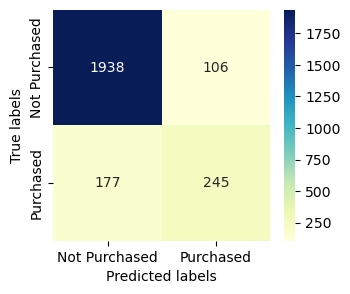

************************************* Classification Report *************************************
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      2044
           1       0.70      0.58      0.63       422

    accuracy                           0.89      2466
   macro avg       0.81      0.76      0.78      2466
weighted avg       0.88      0.89      0.88      2466

************************************* description Table *****************************************


,Description,Misclassifications,Accuracy,Precision,Recall Minority,Recall Majority,Type I errors,Type II errors,F1 Score,F2 Score
0,Logistic Regression,282,0.89,0.7,0.58,0.95,105,177,0.63,0.6
0,Random Forest Classifier,267,0.89,0.76,0.53,0.97,70,197,0.63,0.56
0,Naiye Bayes Classifier,1948,0.21,0.18,0.99,0.05,1945,3,0.3,0.52
0,Decision Tree Classifier,350,0.86,0.59,0.54,0.92,157,193,0.57,0.55
0,Support Vector Classifier,264,0.89,0.72,0.62,0.95,102,162,0.66,0.64
0,ADA Boost Classifier,283,0.89,0.7,0.58,0.95,106,177,0.63,0.6


In [21]:
cmad = metrics.confusion_matrix(y_test, y_pred_ada)
plt.rcParams['figure.figsize'] = (3.5, 3)
ax = sns.heatmap(cmad, fmt = 'g',annot = True,cmap="YlGnBu")
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');  
ax.xaxis.set_ticklabels(['Not Purchased', 'Purchased']); ax.yaxis.set_ticklabels(['Not Purchased', 'Purchased'])
print ("************************************* Confusion Matrix ******************************************")
plt.show()

print ("************************************* Classification Report *************************************")
crad = metrics.classification_report(y_test,y_pred_ada)
print(crad)

print ("************************************* description Table *****************************************")
description = "ADA Boost Classifier"  #change the name of models


admisclassifications = cmad[0,1] + cmad[1,0]         #FP + FN
adtype1 = cmad[0,1]
adtype2 = cmad[1,0]
adr1 = (cmad[1,1]  / (cmad[1,1] + cmad[1,0])).round(2)
adr0 = (cmad[0,0]  / (cmad[0,0] + cmad[0,1])).round(2)
adprecision = round(precision_score(y_test, y_pred_ada),2)
adrecall = round(recall_score(y_test,y_pred_ada),2)
adaccuracy = round(accuracy_score(y_test,y_pred_ada),2)
adf1 = round(f1_score(y_test,y_pred_ada),2)
adauc = round(roc_auc_score(y_test,y_pred_ada),2)
adf2 = ((5 * adprecision * adrecall)/ (4 * adprecision + adrecall)).round(2)

df_results = pd.concat([df_results,pd.DataFrame(np.array
                                                ([description,admisclassifications,adaccuracy, adprecision, adr1,adr0,adtype1,adtype2,adf1,adf2]).reshape(1,-1)
                                     , columns=['Description','Misclassifications','Accuracy','Precision','Recall Minority','Recall Majority'
                                                ,'Type I errors','Type II errors','F1 Score','F2 Score'])
                                  ], axis=0)
df_results

## Gradient Boost Classifier

************************************* Confusion Matrix ******************************************


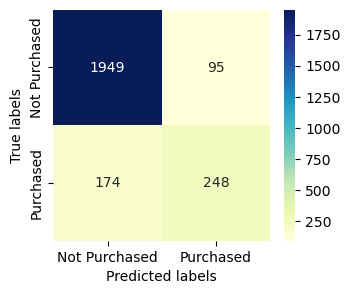

************************************* Classification Report *************************************
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      2044
           1       0.72      0.59      0.65       422

    accuracy                           0.89      2466
   macro avg       0.82      0.77      0.79      2466
weighted avg       0.88      0.89      0.89      2466

************************************* description Table *****************************************


,Description,Misclassifications,Accuracy,Precision,Recall Minority,Recall Majority,Type I errors,Type II errors,F1 Score,F2 Score
0,Logistic Regression,282,0.89,0.7,0.58,0.95,105,177,0.63,0.6
0,Random Forest Classifier,267,0.89,0.76,0.53,0.97,70,197,0.63,0.56
0,Naiye Bayes Classifier,1948,0.21,0.18,0.99,0.05,1945,3,0.3,0.52
0,Decision Tree Classifier,350,0.86,0.59,0.54,0.92,157,193,0.57,0.55
0,Support Vector Classifier,264,0.89,0.72,0.62,0.95,102,162,0.66,0.64
0,ADA Boost Classifier,283,0.89,0.7,0.58,0.95,106,177,0.63,0.6
0,Gradient Boost Classifier,269,0.89,0.72,0.59,0.95,95,174,0.65,0.61


In [22]:
cmgb = metrics.confusion_matrix(y_test, y_pred_gbc)
plt.rcParams['figure.figsize'] = (3.5, 3)
ax = sns.heatmap(cmgb, fmt = 'g',annot = True,cmap="YlGnBu")
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');  
ax.xaxis.set_ticklabels(['Not Purchased', 'Purchased']); ax.yaxis.set_ticklabels(['Not Purchased', 'Purchased'])
print ("************************************* Confusion Matrix ******************************************")
plt.show()

print ("************************************* Classification Report *************************************")
crgb = metrics.classification_report(y_test,y_pred_gbc)
print(crgb)

print ("************************************* description Table *****************************************")
description = "Gradient Boost Classifier"  #change the name of models


gbmisclassifications = cmgb[0,1] + cmgb[1,0]         #FP + FN
gbtype1 = cmgb[0,1]
gbtype2 = cmgb[1,0]
gbr1 = (cmgb[1,1]  / (cmgb[1,1] + cmgb[1,0])).round(2)
gbr0 = (cmgb[0,0]  / (cmgb[0,0] + cmgb[0,1])).round(2)
gbprecision = round(precision_score(y_test, y_pred_gbc),2)
gbrecall = round(recall_score(y_test,y_pred_gbc),2)
gbaccuracy = round(accuracy_score(y_test,y_pred_gbc),2)
gbf1 = round(f1_score(y_test,y_pred_gbc),2)
gbauc = round(roc_auc_score(y_test,y_pred_gbc),2)
gbf2 = ((5 * gbprecision * gbrecall)/ (4 * gbprecision + gbrecall)).round(2)

df_results = pd.concat([df_results,pd.DataFrame(np.array
                                                ([description,gbmisclassifications,gbaccuracy, gbprecision, gbr1,gbr0,gbtype1,gbtype2,gbf1,gbf2]).reshape(1,-1)
                                     , columns=['Description','Misclassifications','Accuracy','Precision','Recall Minority','Recall Majority'
                                                ,'Type I errors','Type II errors','F1 Score','F2 Score'])
                                  ], axis=0)
df_results

## XG Boost Classifier

************************************* Confusion Matrix ******************************************


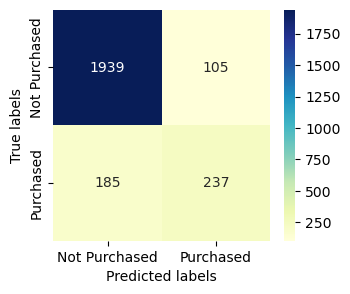

************************************* Classification Report *************************************
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2044
           1       0.69      0.56      0.62       422

    accuracy                           0.88      2466
   macro avg       0.80      0.76      0.78      2466
weighted avg       0.88      0.88      0.88      2466

************************************* description Table *****************************************


,Description,Misclassifications,Accuracy,Precision,Recall Minority,Recall Majority,Type I errors,Type II errors,F1 Score,F2 Score
0,Logistic Regression,282,0.89,0.7,0.58,0.95,105,177,0.63,0.6
0,Random Forest Classifier,267,0.89,0.76,0.53,0.97,70,197,0.63,0.56
0,Naiye Bayes Classifier,1948,0.21,0.18,0.99,0.05,1945,3,0.3,0.52
0,Decision Tree Classifier,350,0.86,0.59,0.54,0.92,157,193,0.57,0.55
0,Support Vector Classifier,264,0.89,0.72,0.62,0.95,102,162,0.66,0.64
0,ADA Boost Classifier,283,0.89,0.7,0.58,0.95,106,177,0.63,0.6
0,Gradient Boost Classifier,269,0.89,0.72,0.59,0.95,95,174,0.65,0.61
0,XGBoost Classifier,290,0.88,0.69,0.56,0.95,105,185,0.62,0.58


In [23]:
cmxg = metrics.confusion_matrix(y_test, y_pred_gb)
plt.rcParams['figure.figsize'] = (3.5, 3)
ax = sns.heatmap(cmxg, fmt = 'g',annot = True,cmap="YlGnBu")
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');  
ax.xaxis.set_ticklabels(['Not Purchased', 'Purchased']); ax.yaxis.set_ticklabels(['Not Purchased', 'Purchased'])
print ("************************************* Confusion Matrix ******************************************")
plt.show()

print ("************************************* Classification Report *************************************")
crgb = metrics.classification_report(y_test,y_pred_gb)
print(crgb)

print ("************************************* description Table *****************************************")
description = "XGBoost Classifier"  #change the name of models


xgmisclassifications = cmxg[0,1] + cmxg[1,0]         #FP + FN
xgtype1 = cmxg[0,1]
xgtype2 = cmxg[1,0]
xgr1 = (cmxg[1,1]  / (cmxg[1,1] + cmxg[1,0])).round(2)
xgr0 = (cmxg[0,0]  / (cmxg[0,0] + cmxg[0,1])).round(2)
xgprecision = round(precision_score(y_test, y_pred_gb),2)
xgrecall = round(recall_score(y_test,y_pred_gb),2)
xgaccuracy = round(accuracy_score(y_test,y_pred_gb),2)
xgf1 = round(f1_score(y_test,y_pred_gb),2)
xgauc = round(roc_auc_score(y_test,y_pred_gb),2)
xgf2 = ((5 * xgprecision * xgrecall)/ (4 * xgprecision + xgrecall)).round(2)

df_results = pd.concat([df_results,pd.DataFrame(np.array
                                                ([description,xgmisclassifications,xgaccuracy, xgprecision, xgr1,xgr0,xgtype1,xgtype2,xgf1,xgf2])
                                                .reshape(1,-1)
                                     , columns=['Description','Misclassifications','Accuracy','Precision','Recall Minority','Recall Majority'
                                                ,'Type I errors','Type II errors','F1 Score','F2 Score'])
                                  ], axis=0)
df_results

### Cross Validation Comparison

In [24]:
def cv_comparison(models, X, y, cv = model_selection.RepeatedStratifiedKFold(n_splits=7, n_repeats=3, random_state=1)):
    # Initiate a DataFrame for the averages and a list for all measures
    cv_accuracies = pd.DataFrame()

    # Loop through the models, run a CV, add the average scores to the DataFrame and the scores of 
    # all CVs to the list
    for model in models:
        recalls = cross_val_score(model, x_train, y_train, scoring='recall', cv=cv)
        recall_score = np.mean(recalls).round(2)
        precisions = cross_val_score(model, x_train, y_train, scoring='precision', cv=cv)
        precision_score = np.mean(precisions).round(2)
        accuracies = cross_val_score(model, x_train,y_train, scoring='accuracy', cv=cv)
        accuracy_score = np.mean(accuracies).round(2)
        aucs = cross_val_score(model, x_train,y_train, scoring='roc_auc', cv=cv)
        auc_score = np.mean(aucs).round(2)
        f1s = cross_val_score(model, x_train,y_train, scoring='f1', cv=cv)
        f1_score = np.mean(accuracies).round(2)
        cv_accuracies[str(model).split('(')[0]] = [ accuracy_score, precision_score, recall_score, auc_score, f1_score]
    cv_accuracies.index = ['Accuracy','Precision','Recall',  'AUC','F1']
    result = cv_accuracies.transpose()
    return result
    # return cv_accuracies

In [25]:
LR = LogisticRegression() 
RF = RandomForestClassifier()
DT = DecisionTreeClassifier()
NB = GaussianNB()
SV = SVC()
AD = AdaBoostClassifier()
GB = GradientBoostingClassifier()
XG = xgb.XGBClassifier()
models = [LR,RF,DT,NB,SV,AD,GB,XG]

In [26]:
import pandas as pd
cv_comparison(models, x_train, y_train)

,Accuracy,Precision,Recall,AUC,F1
LogisticRegression,0.90,0.69,0.60,0.91,0.90
RandomForestClassifier,0.91,0.75,0.54,0.92,0.91
DecisionTreeClassifier,0.86,0.55,0.57,0.74,0.86
GaussianNB,0.19,0.16,0.98,0.69,0.19
SVC,0.90,0.70,0.63,0.91,0.90
AdaBoostClassifier,0.89,0.67,0.56,0.91,0.89
GradientBoostingClassifier,0.91,0.72,0.60,0.93,0.91
XGBClassifier,0.90,0.70,0.58,0.92,0.90
